# VAR Forecasting

<div style='text-align: justify;'>
The forecasting procedure is implemented using a rolling window with a size of 10 trading days. Even though the size of the window is arbitrary selected, it enables the parameters to be updated every 10 forecasts, which adds some non-linearly relationships, especially in the VAR model. The training set consists of 90% of the full sample, and the testing set is 10%.
</div>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import *

In [2]:
def import_data(path):
    # The data were downloaded from investment.com
    # Load Market index logarithmic returns
    df = pd.read_csv(path)

    # Change column name
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

    # Convert string to date time
    df['Date'] = pd.to_datetime(df['Date'])

    # Remove time
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # Set frequency to avoid errors later in the VAR model
    df['Date'] = pd.DatetimeIndex(df['Date']).to_period('B')
    #df['Date'] = pd.DatetimeIndex(df['Date'])
    # Set Datetime index
    df.set_index('Date', inplace=True)
    return df

In [19]:
# Load market index prices
path1="market_indexes.csv"
market_price = import_data(path1)
# 90% of the dataset is used to train the model
end_train=round(len(market_price)*0.9)
market_price=market_price.iloc[0:end,:]
log_market_price = market_price.apply(np.log, axis=0)
market_return = log_market_price - log_market_price.shift(1)
market_return.dropna(inplace=True)

<div style='text-align: justify;'>  
The existing literature demonstrates that the results of the VAR model are affected by the ordering of the variables. The most appropriate way to order the variables is by exploiting the theoretical interconnections between the variables. The market indices that have a direct effect on the other indices should be placed first and variables that do not present immediate effect last. Furthermore, when theory is not straightforward, an efficient way to overcome this issue is to order the variables with respect to the Granger causality test results.
</div>

In [20]:
from statsmodels.tsa.stattools import grangercausalitytests
def grangers_causality_matrix(data, variables, lag_order=3, test = 'ssr_chi2test', verbose=False):
    # Code:
    # https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6
    # https://phdinds-aim.github.io/time_series_handbook/04_GrangerCausality/04_GrangerCausality.html
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=lag_order, verbose=False)

            """x: array_like
            The data for testing whether the time series in the second column Granger
            causes the time series in the first column."""

            p_values = [round(test_result[i+1][0][test][1],4) for i in range(lag_order)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            # H0: X Fails to Granger-Cause Y
            # H1: X Granger-Cause Y
            if min_p_value <= 0.05:
                dataset.loc[r,c] = "YES"
            else:
                dataset.loc[r, c] = "NO"
    for i in range(len(dataset)):
        dataset.iloc[i, i] = '-'
    dataset.columns = [var + '_X' for var in variables]
    dataset.index = [var + '_Y' for var in variables]
    return dataset

In [21]:
# The Granger-Causality test is run for a lag order of five
pairwise_causality = grangers_causality_matrix(market_return, variables = market_return.columns, lag_order=5)
pairwise_causality.head(6)

,Brazil_X,China_X,Germany_X,Greece_X,India_X,US_X
Brazil_Y,-,NO,YES,YES,YES,YES
China_Y,YES,-,YES,YES,YES,YES
Germany_Y,NO,YES,-,YES,YES,YES
Greece_Y,YES,YES,NO,-,YES,YES
India_Y,YES,NO,YES,YES,-,YES
US_Y,YES,NO,YES,YES,YES,-


<div style='text-align: justify;'>  
The theoritical relationship between the market indices showed that the developed markets should be placed first and the emerging last. Then the variables are ordered according to the pairwise causality. All in all, the ordering of the variables is the US, Germany, India, Greece, Brazil, and China.
</div>

In [22]:
# Set the variables ordering according to  theory and pairwise causality
# Dominance and Granger
ordering=[5, 2, 4, 3, 0, 1]
market_return = market_return.iloc[:,ordering].copy()
market_price = market_price.iloc[:,ordering].copy()
market_indices_columns = market_return.columns.values

### Fit VAR model

In [23]:
# All in all, the order of the VAR model will be 5
var_order=5
model = VAR(endog=market_return, dates=market_return.index)
VARResults=model.fit(maxlags=var_order, ic=None)

### Multivariate Granger-Causality Test
<div style='text-align: justify;'>
In order to identify interdependences and simultaneous interactions between the indices, the previous test will be extended to a multivariate setting that is based on a VAR(5) model.
</div>

In [24]:
mult_causality=pd.DataFrame(0, index=market_indices_columns, columns=['Result'])

for i in market_indices_columns:
    results = VARResults.test_causality(i, market_indices_columns[market_indices_columns != i], kind='f')
    p_value=results.pvalue
    if p_value <= 0.05:
        mult_causality.loc[i] = 'Granger-Caused'
    else:
        mult_causality.loc[i] = 'Failed Granger-Caused'
mult_causality.head(6)

,Result
US,Granger-Caused
Germany,Granger-Caused
India,Granger-Caused
Greece,Granger-Caused
Brazil,Granger-Caused
China,Granger-Caused


### Results
<div style='text-align: justify;'>
In every case the p-value is close to zero. As a result, the alternative hypothesis, that the market indices Granger-Cause the market index, should be accepted. This is an initial indication that VAR(5) model is possible to provide useful information in a forecasting procedure.
</div>

In [56]:
# Load all the returns without splitting the dataset
# Load market index returns
path1="market_indexes_ret.csv"
temp = import_data(path1)
end_train = round(len(temp)*0.90)

# Set variables ordering
ordering=[5, 2, 4, 3, 0, 1]
market_return=temp.iloc[:,ordering].copy()
market_indices_columns = market_return.columns.values
num_of_variables=len(market_indices_columns)

In [57]:
# Set rolling window
window = 10
end_test = market_return.shape[0]
forecasts_ret=pd.DataFrame()
for i,start_test in enumerate(range(end_train,end_test,window)):
    # Split the data into training and testing samples
    if (end_test - start_test) >= window:
        start_train= i*window
        train_set = market_return.iloc[start_train:start_test,:]
        test_set = market_return.iloc[start_test:(start_test+window),:]
    else:
        window2 = end_test - start_test
        start_train = i * window + window2
        train_set = market_return.iloc[start_train:start_test, :]
        test_set = market_return.iloc[start_test:start_test+window2,:]

        # From previous section
    var_order = 5

    model = VAR(endog=train_set, dates=train_set.index)

    VARResults = model.fit(maxlags=var_order, ic=None)
    # Estimate VAR

    # Forecast
    y = train_set.values[-var_order:]

    forecasts_temp = pd.DataFrame(VARResults.forecast(y, steps=test_set.shape[0]))

    forecasts_ret=pd.concat([forecasts_ret,forecasts_temp], ignore_index=True, sort=False)

forecasts_ret = pd.DataFrame(data=forecasts_ret.values, index=market_return.iloc[end_train:,:].index, columns=market_indices_columns)

In [58]:
def logret2price(forecasts_ret, initial_price, columns):

    """
    The aim of this function is to convert the logarithmic return to price
    https://stackoverflow.com/questions/55892584/convert-log-returns-to-actual-price-of-a-time-series-forecast-using-r
    """

    forecast_prices = forecasts_ret.copy()
    for col in columns:
        forecast_prices[str(col)] = initial_price[str(col)]*np.exp(forecast_prices[str(col)].cumsum())
    return forecast_prices

In [59]:
# Load market index prices
path2="market_indexes.csv"
temp = import_data(path2)
market_prices=temp.iloc[:,ordering].copy()

# The market prices at the last day of the training set
initial_price=market_prices.iloc[(end_train-1),:]


# Convert the logarithmic return to price
forecast_prices = logret2price(forecasts_ret, initial_price, market_indices_columns)

## Plot the results

In [60]:
# Convert them because otherwise matplotlib raise error because the dates are periods and not datetime
dates_act=market_prices.index.to_timestamp(freq=None, how='start')
dates_for=forecast_prices.index.to_timestamp(freq=None, how='start')

dates_act2=market_return.index.to_timestamp(freq=None, how='start')
dates_for2=forecasts_ret.index.to_timestamp(freq=None, how='start')

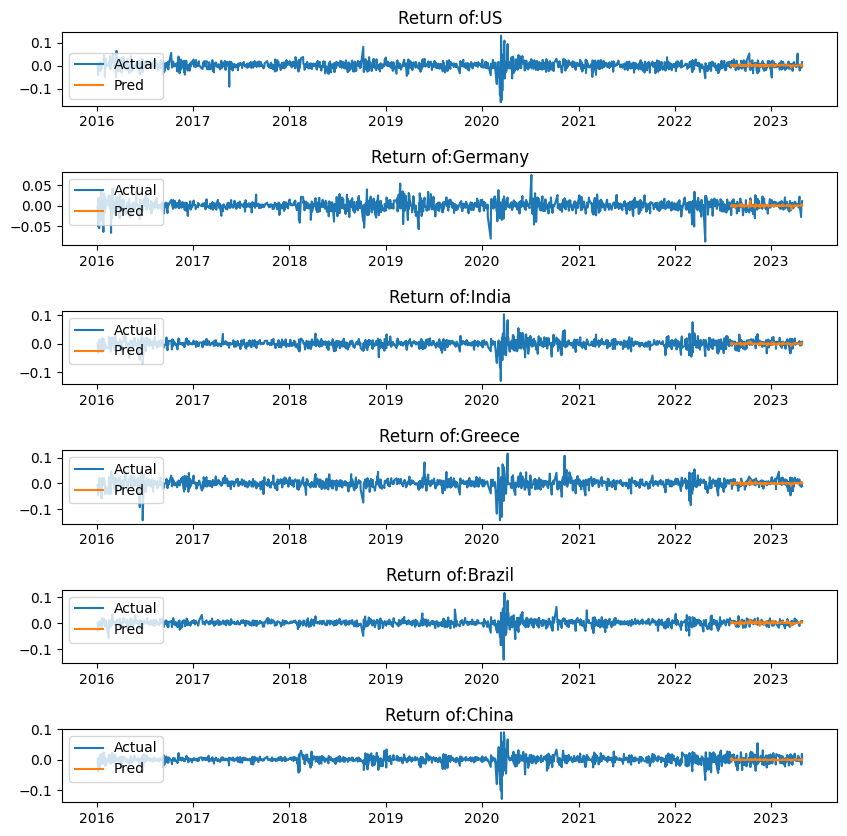

In [61]:
fig1, axes1 = plt.subplots(nrows=6,ncols=1,figsize=(10,10))
fig1.subplots_adjust(hspace=.9,wspace=0.4)
for i, ax1 in enumerate(axes1.flatten()):
    # Plot Returns
    ax1.set_title('Return of:' + market_indices_columns[i])

    sc11 = ax1.plot(dates_act2, market_index_ret.iloc[:,i], label="Actual")
    sc12 = ax1.plot(dates_for2, forecasts_ret.iloc[:,i], label="Pred")
    sc1 = sc11 + sc12
    labs1 = [s.get_label() for s in sc1]
    ax1.legend(sc1, labs1)
plt.show()

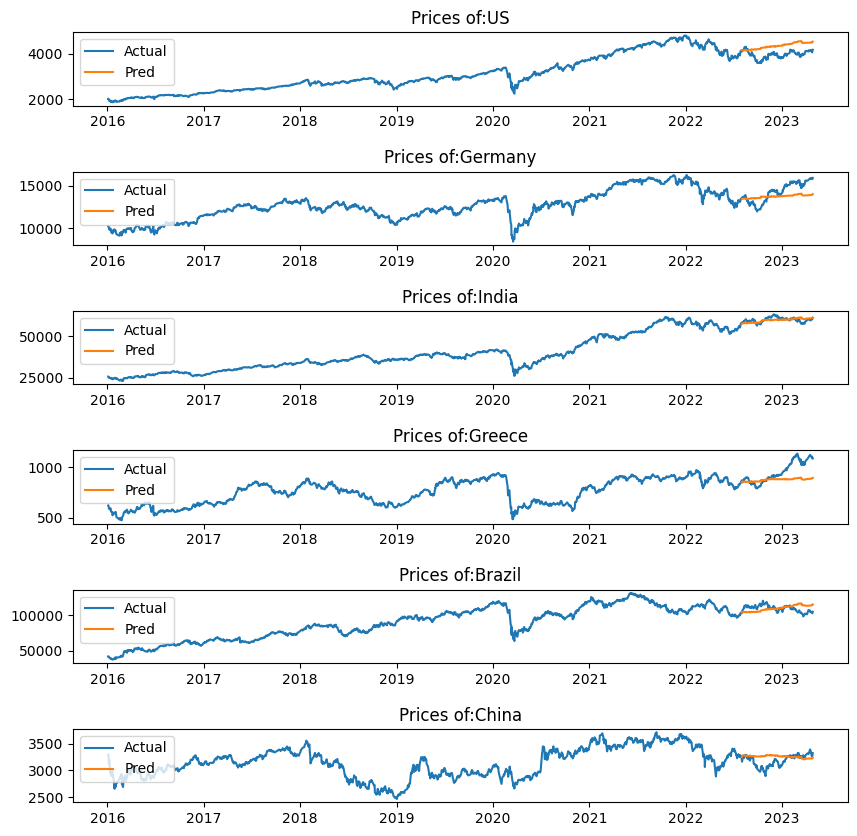

In [62]:
fig2, axes2 = plt.subplots(nrows=6,ncols=1,figsize=(10,10))
fig2.subplots_adjust(hspace=.9,wspace=0.4)
for i, ax2 in enumerate(axes2.flatten()):
    # Plot prices
    ax2.set_title("Prices of:" + market_indices_columns[i])

    sc21 = ax2.plot(dates_act, market_prices.iloc[:,i], label="Actual")
    sc22 = ax2.plot(dates_for, forecast_prices.iloc[:,i], label="Pred")
    sc2 = sc21 + sc22
    labs2 = [s.get_label() for s in sc2]
    ax2.legend(sc2, labs2)
plt.show()

### Results
<div style='text-align: justify;'>
As the VAR tries to establish linear dependences, the accuracy of the model in the short term or during shocks is not the most appropriate one. For instance, Greece and Germany presented an unexpected upward trend after 2023, that is not captured by the model. However, in the case of India, the results of the model are adequate enough, as Sensex did not fluctuate a lot.
    </div>

## Evaluation measures

In [63]:
def forecast_errors(actual, pred):
    # Make sure that actual and pred have the same size
    if actual.shape != pred.shape:
        raise IndexError("Actual and Pred matrix do not have the same size")
    fe = actual - pred
    return fe

In [64]:
# Mean square Error
def my_mse(actual, pred):
    f_errors = forecast_errors(actual, pred)
    mse = (f_errors ** 2).mean(0)
    return mse


# Root Mean Square Error (RMSE)
def my_rmse(actual, pred):
    mse = my_mse(actual, pred)
    rmse = mse ** 0.5
    return rmse


# Mean absolute error
def my_mae(actual, pred):
    f_errors = forecast_errors(actual, pred)
    mae = f_errors.abs().mean(0)
    return mae

In [65]:
def my_bcm(actual, pred):
    # Make sure that actual and pred have the same size
    if actual.shape != pred.shape:
        raise IndexError("Actual and Pred matrix do not have the same size")

    # When the return is positive it becomes True otherwise False
    binary_actual=actual > 0
    binary_pred = pred > 0

    bcm = pd.DataFrame(0, index=['Pred_Pos', 'Pred_Neg'], columns=['Act_Neg', 'Act_Pos'])

    for row in range(actual.shape[0]):
        if (binary_actual.iloc[row] == True) and (binary_pred.iloc[row] == True):
            bcm.iloc[0, 1] += 1

        elif (binary_actual.iloc[row] == True) and (binary_pred.iloc[row] == False):
            bcm.iloc[1, 1] += 1

        elif (binary_actual.iloc[row] == False) and (binary_pred.iloc[row] == True):
            bcm.iloc[0, 0] += 1

        elif (binary_actual.iloc[row] == False) and (binary_pred.iloc[row] == False):
            bcm.iloc[1, 0] += 1
    return bcm


def my_mult_bcm(actual, pred):
    """
    Estimates the binary confusion matrix for every market
    """
    # Make sure that actual and pred have the same size
    if actual.shape != pred.shape:
        raise IndexError("Actual and Pred matrix do not have the same size")

    mbcm = []
    for col in range(actual.shape[1]):
        bcm = my_bcm(actual.iloc[:,col], pred.iloc[:,col])
        mbcm.append(bcm)
    return mbcm


In [66]:
# Precision
def my_precision(actual, pred):
    mbcm = my_mult_bcm(actual, pred)
    precision=pd.DataFrame(0, index=actual.columns, columns=['Precision'])
    for i in range(len(mbcm)):
        bsm = mbcm[i]
        precision.iloc[i,0] = (bsm.iloc[0,1]/(bsm.iloc[0,1]+bsm.iloc[0,0]))
    return precision


# Recall
def my_recall(actual, pred):
    mbcm = my_mult_bcm(actual, pred)
    recall = pd.DataFrame(0, index=actual.columns, columns=['Recall'])
    for i in range(len(mbcm)):
        bsm = mbcm[i]
        recall.iloc[i,0] = (bsm.iloc[0,1]/(bsm.iloc[0,1]+bsm.iloc[1,1]))
    return recall


# F1 Score
def my_f1(actual, pred):
    f1 = pd.DataFrame(0, index=actual.columns, columns=['F1_score'])
    precision = my_precision(actual, pred)
    recall = my_recall(actual, pred)
    for i in range(len(actual.columns)):
        f1.iloc[i,0] = 2*((precision.iloc[i,0]*recall.iloc[i,0])/(precision.iloc[i,0]+recall.iloc[i,0]))
    return f1

In [67]:
def my_eval_meas(actual, pred):
    eval_meas=pd.DataFrame(0, index= actual.columns, columns=['MSE', 'RMSE', 'MAE', 'Precision', 'Recall', 'F1_Score'])
    eval_meas['MSE'] = my_mse(actual, pred)
    eval_meas['RMSE'] = my_rmse(actual, pred)
    eval_meas['MAE'] = my_mae(actual, pred)


    eval_meas['Precision'] = my_precision(actual, pred)
    eval_meas['Recall'] = my_recall(actual, pred)
    eval_meas['F1_Score'] = my_f1(actual, pred)
    return eval_meas

In [68]:
Evaluation_Measures = my_eval_meas(market_index_ret.iloc[end_train:,:], forecasts_ret)
Evaluation_Measures.head(6)

,MSE,RMSE,MAE,Precision,Recall,F1_Score
Brazil,0.000218,0.014773,0.011406,0.558559,0.775000,0.649215
China,0.000092,0.009579,0.006947,0.490196,0.684932,0.571429
Germany,0.000134,0.011589,0.008746,0.622951,0.817204,0.706977
Greece,0.000148,0.012175,0.008802,0.598131,0.719101,0.653061
India,0.000069,0.008326,0.006390,0.545455,0.697674,0.612245
US,0.000178,0.013329,0.010563,0.469136,0.527778,0.496732



Someone could infer that in terms of magnitude the forecasts of India and China have superior performance. From the other hand, with respect to the measures of direction, Greece and Germany have the optimal results as the values of F1 score are 65.31% and 68.27% correspondingly.

## References
* Brooks, C. (2008). Introductory Econometrics for Finance (2nd ed.). Cambridge University Press.  
* Sims, C. (1980). Macroeconomics and Reality. Econometrica, 48(1), 1-48. doi:https://doi.org/10.2307/1912017